# Predict Default

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, Pipeline, pipeline, evaluation, tuning, clustering
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = spark.read.csv('acceptedloansdata.csv', header=True, sep=",", inferSchema=True).\
    drop('_c0')

In [3]:
#1. dummy variables for loans charged off/late
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='loan_status', outputCol='encodedstatus')
df = df.filter((df.loan_status != 'Current'))
df = df.filter((df.loan_status != 'In Grace Period'))
df = df.filter((df.loan_status != 'Late (31-120 days)'))
df = df.filter((df.loan_status != 'Late (16-30 days)'))
df = indexer.fit(df).transform(df)
df = df.withColumn('label', fn.when(fn.col('encodedstatus') > 0, 1.0).otherwise(0.))

In [4]:
from pyspark.sql.types import IntegerType
df = df.withColumn('label', fn.col('label').cast(IntegerType()))

In [5]:
df = df.toPandas()

In [6]:
perc = 1.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df = df.dropna( axis=1, 
                thresh=min_count)

### Correlation: Feature Selection for Logistic Regression and Random Forest

- should variance inflation factor be used to fix multicolinearity ?

<AxesSubplot:>

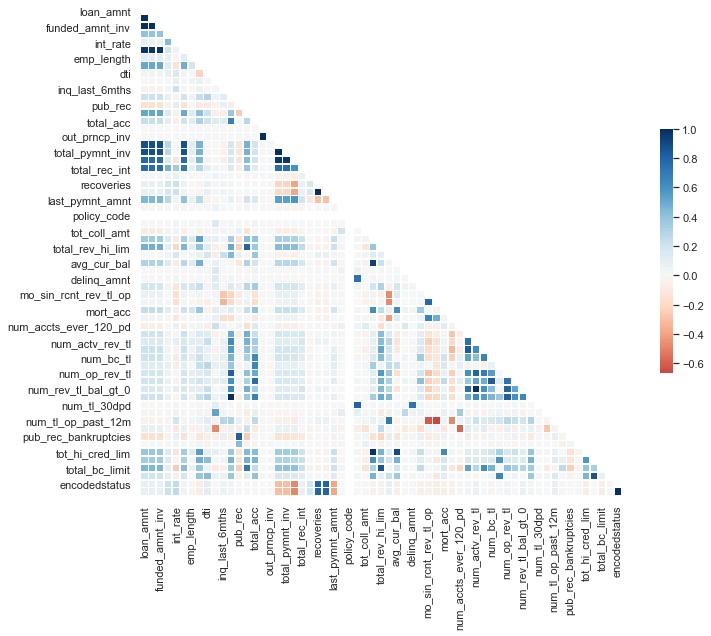

In [7]:
sns.set(style="white")
dfp = df
corr = dfp.corr(method='spearman')
corr
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = "RdBu"
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

Split features into the following variable sets:

### 1. financial info

- inq_last_6mths	The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

- mths_since_last_record	The number of months since the last public record.

-  dti	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

- pub_rec	Number of derogatory public records

- total_acc	The total number of credit lines currently in the borrower's credit file

- mo_sin_old_il_acct	Months since oldest bank installment account opened

- mths_since_recent_bc_dlq	Months since most recent bankcard delinquency

- mort_acc	Number of mortgage accounts.

- num_actv_bc_tl	Number of currently active bankcard accounts

- num_bc_sats	Number of satisfactory bankcard accounts

- num_il_tl	Number of installment accounts

- num_bc_sats	Number of satisfactory bankcard accounts

- num_rev_accts	Number of revolving accounts

- num_sats	Number of satisfactory accounts

- num_tl_30dpd	Number of accounts currently 30 days past due (updated in past 2 months)

- percent_bc_gt_75	Percentage of all bankcard accounts > 75% of limit.

- tax_liens	Number of tax liens

- total_bal_ex_mort	Total credit balance excluding mortgage

- total_il_high_credit_limit	Total installment high credit/credit limit

- purpose	A category provided by the borrower for the loan request. 

- open_acc	The number of open credit lines in the borrower's credit file.


    
### 2. lending club info 

- loan_amnt	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

- int_rate	Interest Rate on the loan

- grade	LC assigned loan grade

- total_rec_int	Interest received to date

- last_pymnt_amnt	Last total payment amount received

- mths_since_last_major_derog	Months since most recent 90-day or worse rating

- acc_now_delinq	The number of accounts on which the borrower is now delinquent.

- tot_cur_bal	Total current balance of all accounts

- acc_open_past_24mths	Number of trades opened in past 24 months.

- bc_open_to_buy	Total open to buy on revolving bankcards.

- chargeoff_within_12_mths	Number of charge-offs within 12 months

- pymnt_plan	Indicates if a payment plan has been put in place for the loan


### 3. investment info

- funded_amnt_inv	The total amount committed by investors for that loan at that point in time.

- out_prncp_inv	Remaining outstanding principal for portion of total amount funded by investors

- total_pymnt_inv	Payments received to date for portion of total amount funded by investors

### 4. demographic info 

- emp_title	The job title supplied by the Borrower when applying for the loan.

- emp_length	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

- addr_state	The state provided by the borrower in the loan application

- application_type	Indicates whether the loan is an individual application or a joint application with two co-borrowers

- annual_inc	The self-reported annual income provided by the borrower during registration.

- home_ownership	The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER



# Logistic Regression 1 

In [20]:
features_list = ['annual_inc',
                 'loan_amnt', 
                 'int_rate',
                 'emp_length', 
                 'dti', 
                 'delinq_2yrs', 
                 'open_acc', 
                 'revol_bal', 
                 'total_acc', 
                 'purpose', 
                 'region', 
                 'term', 
                 'grade']     

In [21]:
df = spark.createDataFrame(df)

In [22]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.3, 0.1])

In [25]:
from pyspark.ml import classification
features_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols= ['annual_inc','loan_amnt', 'int_rate','emp_length', 'dti', 'delinq_2yrs', 'open_acc', 'revol_bal', 'total_acc'], outputCol='nfeatures'),
                                        feature.StringIndexer(inputCol='purpose', outputCol='spurpose'), 
                                        feature.OneHotEncoder(inputCol='spurpose', outputCol='encoded_purpose'), 
                                        feature.StringIndexer(inputCol='addr_state', outputCol='sstate'), 
                                        feature.OneHotEncoder(inputCol='sstate', outputCol='encoded_state'),  
                                        feature.StringIndexer(inputCol='term', outputCol='t'), 
                                        feature.OneHotEncoder(inputCol='t', outputCol='encoded_term'), 
                                        feature.StringIndexer(inputCol='grade', outputCol='g'), 
                                        feature.OneHotEncoder(inputCol='g', outputCol='encoded_grade'), 
                                        feature.VectorAssembler(inputCols=['encoded_grade','encoded_term','encoded_state','encoded_purpose', 'nfeatures'], outputCol='features'), 
                                        classification.LogisticRegression(featuresCol='features', labelCol='label')])

In [26]:
model = features_pipe.fit(training_df)

In [27]:
pd.DataFrame(list(zip(features_list, model.stages[-1].coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=True)

,column,weight
6,open_acc,-0.673558
3,emp_length,-0.497545
11,term,-0.351590
9,purpose,-0.296352
7,revol_bal,-0.274637
12,grade,-0.234980
10,region,-0.219360
1,loan_amnt,-0.139913
8,total_acc,-0.128300
5,delinq_2yrs,-0.034754


In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
bce = BinaryClassificationEvaluator()
bce.evaluate(model.transform(validation_df))

0.7157492123585163

# Logistic Regression  2

In [29]:
va = VectorAssembler().setInputCols(['loan_amnt', 
                                     'int_rate',
                                     'term',
                                     'emp_length', 
                                     'dti', 'open_acc', 'revol_bal','total_acc']).setOutputCol('features')



In [30]:
lr2 = LogisticRegression(featuresCol='features', labelCol='label')
model2 = Pipeline(stages=[va, lr2]).fit(training_df)

In [31]:
pd.DataFrame(list(zip(va.getInputCols(), model2.stages[-1].coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=True)

,column,weight
3,emp_length,-0.021413
7,total_acc,-0.009629
6,revol_bal,-0.000009
0,loan_amnt,0.000004
5,open_acc,0.021090
2,term,0.029835
4,dti,2.428540
1,int_rate,11.622163


In [32]:
bce.evaluate(model2.transform(validation_df))

0.7108320281606141

# Logistic Regression 3

In [33]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.3, 0.1])

In [34]:
from pyspark.ml import classification
features_pipe3 = Pipeline(stages=[feature.VectorAssembler(inputCols= ['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'policy_code',
 'mort_acc',
 'pub_rec_bankruptcies'], outputCol='nfeatures'),
                                        feature.StandardScaler(inputCol='nfeatures', outputCol='scfeatures'),
                                        feature.StringIndexer(inputCol='Month', outputCol='smonth'),
                                        feature.OneHotEncoder(inputCol='smonth', outputCol='encoded_month'), 
                                        feature.StringIndexer(inputCol='purpose', outputCol='spurpose'), 
                                        feature.OneHotEncoder(inputCol='spurpose', outputCol='encoded_purpose'), 
                                        feature.StringIndexer(inputCol='addr_state', outputCol='sstate'), 
                                        feature.OneHotEncoder(inputCol='sstate', outputCol='encoded_state'), 
                                        feature.VectorAssembler(inputCols=['encoded_state','encoded_purpose', 'encoded_month','scfeatures'], outputCol='features'), 
                                        classification.LogisticRegression(featuresCol='features', labelCol='label')]).fit(training_df)



In [35]:
features_list3 = ['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'policy_code',
 'mort_acc',
 'pub_rec_bankruptcies', 'Month', 'purpose', 'addr_state']

In [36]:
pd.DataFrame(list(zip(features_list3, features_pipe3.stages[-1].coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=True)

,column,weight
16,addr_state,-2.517059
15,purpose,-2.510015
8,pub_rec,-2.376339
4,emp_length,-2.321919
2,int_rate,-2.254463
7,open_acc,-2.248817
14,Month,-2.238808
0,loan_amnt,-2.237145
12,mort_acc,-2.230747
11,policy_code,-2.230207


In [37]:
features_pipe3.stages[-1].intercept

-4.081551707114087

In [38]:
bce.evaluate(features_pipe3.transform(validation_df))

0.7204649716341551


# Logistic Regression  4

In [39]:
features_list4 = ['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'policy_code',
 'mort_acc',
 'pub_rec_bankruptcies']

va2 = VectorAssembler().setInputCols(['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'policy_code',
 'mort_acc',
 'pub_rec_bankruptcies']).setOutputCol('features')
lr2 = LogisticRegression()
model4 = Pipeline(stages=[va2, lr2]).fit(training_df)
pd.DataFrame(list(zip(va2.getInputCols(), model4.stages[-1].coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=True)

,column,weight
12,mort_acc,-0.060440
4,emp_length,-0.011898
10,total_acc,-0.003866
0,loan_amnt,-0.000020
9,revol_bal,-0.000006
5,annual_inc,-0.000002
11,policy_code,0.000000
3,installment,0.000969
8,pub_rec,0.011590
7,open_acc,0.015993


In [40]:
model4.stages[-1].intercept

-4.795693780336307

In [41]:
bce.evaluate(model4.transform(validation_df))

0.7177565061984721

#  Random Forest # 1

In [42]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.3, 0.1])

In [45]:
features_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols= ['annual_inc','loan_amnt', 'int_rate','emp_length', 'dti', 'delinq_2yrs', 'open_acc', 'revol_bal', 'total_acc'], outputCol='nfeatures'),
                                        feature.StringIndexer(inputCol='purpose', outputCol='spurpose'), 
                                        feature.OneHotEncoder(inputCol='spurpose', outputCol='encoded_purpose'), 
                                        feature.StringIndexer(inputCol='addr_state', outputCol='sstate'), 
                                        feature.OneHotEncoder(inputCol='sstate', outputCol='encoded_state'),  
                                        feature.StringIndexer(inputCol='term', outputCol='t'), 
                                        feature.OneHotEncoder(inputCol='t', outputCol='encoded_term'), 
                                        feature.StringIndexer(inputCol='grade', outputCol='g'), 
                                        feature.OneHotEncoder(inputCol='g', outputCol='encoded_grade'), 
                                        feature.VectorAssembler(inputCols=['encoded_grade','encoded_term','encoded_state','encoded_purpose', 'nfeatures'], outputCol='features')])

In [48]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features')
rf_model1 = Pipeline(stages=[features_pipe, rf]).fit(training_df)
pd.DataFrame(list(zip(features_list, rf_model1.stages[-1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
6,open_acc,0.208423
2,int_rate,0.116139
4,dti,0.097576
1,loan_amnt,0.069827
5,delinq_2yrs,0.066586
3,emp_length,0.053145
0,annual_inc,0.017631
9,purpose,0.001621
10,region,0.000391
8,total_acc,0.000373


In [49]:
bce.evaluate(rf_model1.transform(validation_df))

0.7027632111357343

# Random Forest # 2

In [50]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features')
rf_model2 = Pipeline(stages=[va, rf]).fit(training_df)
pd.DataFrame(list(zip(va.getInputCols(), rf_model2.stages[-1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
2,term,0.481547
1,int_rate,0.301024
4,dti,0.106018
0,loan_amnt,0.040968
6,revol_bal,0.031409
3,emp_length,0.020919
7,total_acc,0.010624
5,open_acc,0.007491


In [51]:
bce.evaluate(rf_model2.transform(validation_df))

0.6813466364218439

# Random Forest # 3

In [52]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features')
rf_model3 = Pipeline(stages=[va2, rf]).fit(training_df)
pd.DataFrame(list(zip(va2.getInputCols(), rf_model2.stages[-1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
2,int_rate,0.481547
1,term,0.301024
4,emp_length,0.106018
0,loan_amnt,0.040968
6,dti,0.031409
3,installment,0.020919
7,open_acc,0.010624
5,annual_inc,0.007491


In [53]:
bce.evaluate(rf_model3.transform(validation_df))

0.6984807214444626

# Random Forest 4

In [ ]:
features_pipe3 = Pipeline(stages=[feature.VectorAssembler(inputCols= ['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'policy_code',
 'mort_acc',
 'pub_rec_bankruptcies'], outputCol='nfeatures'),
                                        feature.StandardScaler(inputCol='nfeatures', outputCol='scfeatures'),
                                        feature.StringIndexer(inputCol='Month', outputCol='smonth'),
                                        feature.OneHotEncoder(inputCol='smonth', outputCol='encoded_month'), 
                                        feature.StringIndexer(inputCol='purpose', outputCol='spurpose'), 
                                        feature.OneHotEncoder(inputCol='spurpose', outputCol='encoded_purpose'), 
                                        feature.StringIndexer(inputCol='addr_state', outputCol='sstate'), 
                                        feature.OneHotEncoder(inputCol='sstate', outputCol='encoded_state'), 
                                        feature.VectorAssembler(inputCols=['encoded_state','encoded_purpose', 'encoded_month','scfeatures'], outputCol='features')])


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 60759)
Traceback (most recent call last):
  File "/Users/courtneyhrdy/opt/anaconda3/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/courtneyhrdy/opt/anaconda3/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/courtneyhrdy/opt/anaconda3/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/courtneyhrdy/opt/anaconda3/lib/python3.8/socketserver.py", line 720, in __init__
    self.handle()
  File "/Users/courtneyhrdy/opt/anaconda3/lib/python3.8/site-packages/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/Users/courtneyhrdy/opt/anaconda3/lib/python3.8/site-packages/pyspark/accumulators.py", line 235, in poll
    if 

In [ ]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features')
rf_model4 = Pipeline(stages=[features_pipe3, rf]).fit(training_df)
pd.DataFrame(list(zip(features_list3, rf_model1.stages[-1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)

In [ ]:
bce.evaluate(rf_model4.transform(validation_df))